# Логистическая регрессия

## Домашнее задание

1. Измените функцию predict(w, X) так, чтобы можно было подать порог для классификации.
2. Подберите аргументы функции optimize для логистической регрессии таким образом, чтобы log loss был минимальным.
3. Посчитайте Accuracy, матрицу ошибок, точность и полноту, а также F1 score.
4. Постройте кривую оббучения (значение оценки потерь от итерации) для примеров из тренировочной и тестовой выборки
5. Оцените результаты и сделайте выводы. 
6. Попробуйте ответить на вопросы: Могла ли модель переобучиться? На каком шаге это произошло? Почему?



In [1]:
#%matplotlib notebook
#%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

#%matplotlib inline

In [2]:
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

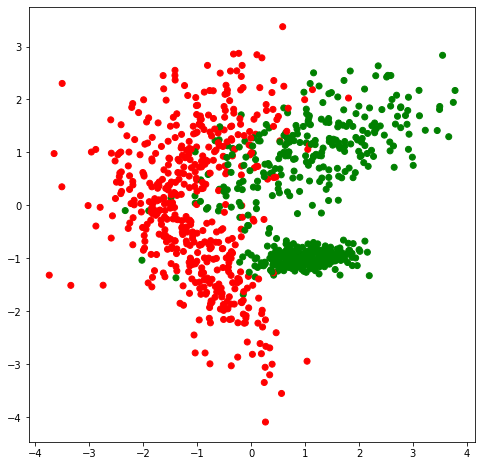

In [3]:
from sklearn import datasets
from matplotlib.colors import ListedColormap

# сгеренируем данные с помощью sklearn.datasets
classes = datasets.make_classification(n_samples=1000, n_features=2, n_informative=2,
                                       n_redundant=0, n_classes=2, random_state=110)
# 

#classes = datasets.make_blobs(n_samples=1000,centers = 2, cluster_std = 1., random_state=12)

# и изобразим их на графике
colors = ListedColormap(['red', 'blue','green'])

plt.figure(figsize=(8, 8))
plt.scatter([x[0] for x in classes[0]], [x[1] for x in classes[0]], c=classes[1], cmap=colors)
plt.show()

In [4]:
classes[0].shape

(1000, 2)

In [5]:
# перемешивание датасета
np.random.seed(12)
shuffle_index = np.random.permutation(classes[0].shape[0])
X_shuffled, y_shuffled = classes[0][shuffle_index], classes[1][shuffle_index]

# разбивка на обучающую и тестовую выборки
train_proportion = 0.9
train_test_cut = int(len(classes[0]) * train_proportion)

X_train, X_test, y_train, y_test = \
    X_shuffled[:train_test_cut], \
    X_shuffled[train_test_cut:], \
    y_shuffled[:train_test_cut], \
    y_shuffled[train_test_cut:]
    
print("Размер массива признаков обучающей выборки", X_train.shape)
print("Размер массива признаков тестовой выборки", X_test.shape)
print("Размер массива ответов для обучающей выборки", y_train.shape)
print("Размер массива ответов для тестовой выборки", y_test.shape)

Размер массива признаков обучающей выборки (900, 2)
Размер массива признаков тестовой выборки (100, 2)
Размер массива ответов для обучающей выборки (900,)
Размер массива ответов для тестовой выборки (100,)


In [6]:
X_train_tr = X_train.transpose()
y_train_tr = y_train.reshape(1, y_train.shape[0])
X_test_tr = X_test.transpose()
y_test_tr = y_test.reshape(1, y_test.shape[0])

In [7]:
def log_loss(w, X, y):
    m = X.shape[1]

    # используем функцию сигмоиды, написанную ранее
    A = sigmoid(np.dot(w.T, X))
    
    loss = -1.0 / m * np.sum(y * np.log(A) + (1 - y) * np.log(1 - A))
    loss = np.squeeze(loss)
    grad = 1.0 / m * np.dot(X, (A - y).T)
    
    return loss, grad

Допишем еще условие выхода из цикла вместо кол-ва итераций

In [8]:
def optimize(w, X, y, n_iterations, eta):
#     потери будем записывать в список для отображения в виде графика
    losses = []
    prev_loss = np.infty
    for i in range(n_iterations):
        loss, grad = log_loss(w, X, y)
        w = w - eta * grad
        if np.abs(loss - prev_loss) <= 1e-10:
            return w, losses

        losses.append(loss)
        
    return w, losses

и функцию для выполнения предсказаний

## №1 

Измените функцию predict(w, X) так, чтобы можно было подать порог для классификации.

In [9]:
def predict(w, X, threshold = 0.5):
    
    m = X.shape[1]
    
    y_predicted = np.zeros((1, m))
    w = w.reshape(X.shape[0], 1)
    
    A = sigmoid(np.dot(w.T, X))
    
#     За порог отнесения к тому или иному классу примем вероятность 0.5 -> threshold
    for i in range(A.shape[1]):
        if (A[:,i] > threshold): 
            y_predicted[:, i] = 1
        elif (A[:,i] <= threshold):
            y_predicted[:, i] = 0
    
    return y_predicted

In [10]:
# иницилизируем начальный вектор весов
w0 = np.zeros((X_train_tr.shape[0], 1))-1

n_iterations = 20
eta = 0.55

w, losses = optimize(w0, X_train_tr, y_train_tr, n_iterations, eta)

y_predicted_test = predict(w, X_test_tr)
y_predicted_train = predict(w, X_train_tr)

# В качестве меры точности возьмем долю правильных ответов
train_accuracy = 100.0 - np.mean(np.abs(y_predicted_train - y_train_tr)*100.0)
test_accuracy = 100.0 - np.mean(np.abs(y_predicted_test-y_test_tr)*100.0)

print(f"Итоговый вектор весов w: {w}")
print(f"Точность на обучающей выборке: {train_accuracy:.3f}")
print(f"Точность на тестовой выборке: {test_accuracy:.3f}")

Итоговый вектор весов w: [[ 1.70057405]
 [-0.0716665 ]]
Точность на обучающей выборке: 89.000
Точность на тестовой выборке: 88.000


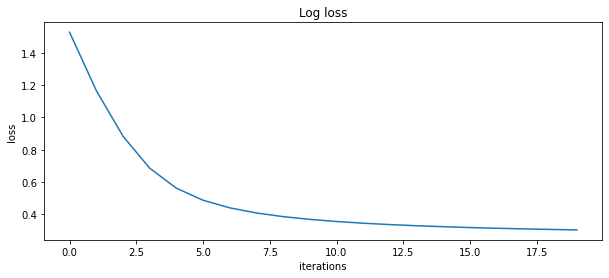

In [11]:
plt.figure(figsize=(10, 4))
plt.title('Log loss')
plt.xlabel('iterations')
plt.ylabel('loss')
plt.plot(range(len(losses)), losses)
plt.show()

## №2

Подберите аргументы функции optimize для логистической регрессии таким образом, чтобы log loss был минимальным.

Ниже выведен лучший logloss, достигнутый на вебинаре, попробуем улучшить

In [12]:
losses[-1]

0.3027127414281867

In [13]:
def train_n_predict(n_iterations = 100, eta = 0.55):

    w0 = np.zeros((X_train_tr.shape[0], 1))-1
    w, losses = optimize(w0, X_train_tr, y_train_tr, n_iterations, eta)

    y_predicted_test = predict(w, X_test_tr)
    y_predicted_train = predict(w, X_train_tr)

    # В качестве меры точности возьмем долю правильных ответов
    train_accuracy = 100.0 - np.mean(np.abs(y_predicted_train - y_train_tr)*100.0)
    test_accuracy = 100.0 - np.mean(np.abs(y_predicted_test-y_test_tr)*100.0)
#    print(eta)
    return w, train_accuracy, test_accuracy, losses


In [14]:
w, train_accuracy, test_acuracy, losses = train_n_predict()

In [15]:
losses[-1]

0.26892572877936516

In [16]:
eta_seq = np.arange(0., 10., 1e-1)
result = {}
W_i = []
for eta in eta_seq:
    w, train_accuracy, test_acuracy, losses = train_n_predict(eta = eta)
    result[losses[-1]] =  [w, train_accuracy, test_accuracy, eta]

In [17]:
min(result.keys())

0.2682658853081602

In [18]:
result[min(result.keys())]

[array([[ 2.87020280e+00],
        [-1.41569677e-03]]),
 89.11111111111111,
 88.0,
 9.200000000000001]

Таким образом, минимальный logloss был достигнут при $\eta$ = 9.2

### Снова вопрос:

В каком диапазоне вообще разумно искать оптимальный $\eta$? Этот был нащупан в цикле, с взятыми заранее границами, если честно, почти наобум

## №3


Посчитайте 
* Accuracy 
* матрицу ошибок 
* точность
* полноту
* а также F1 score.

_Вот тут, если честно, не совсем понял, что именно от нас ожидается. Матрица ошибок будет зависеть от порога, а значит нам его надо как-то выбрать сперва. Я попробую найти такой, при котором просто максимальна точность при трейне._

То есть сейчас пройдемся в цикле по treshold, чтобы выявить "лучший"

In [19]:
w = result[min(result.keys())][0]
w

array([[ 2.87020280e+00],
       [-1.41569677e-03]])

In [20]:
train_accuracy, test_accuracy

(89.11111111111111, 88.0)

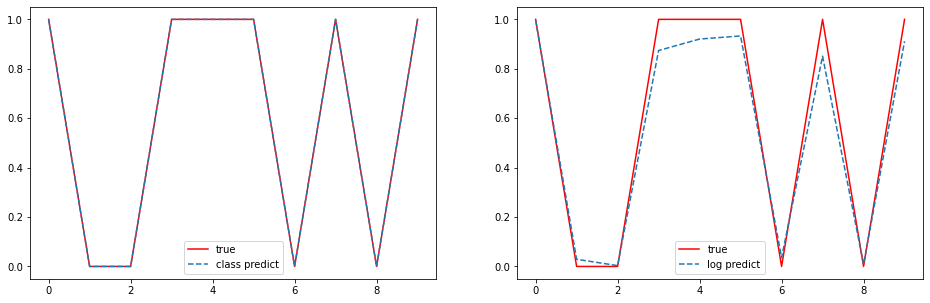

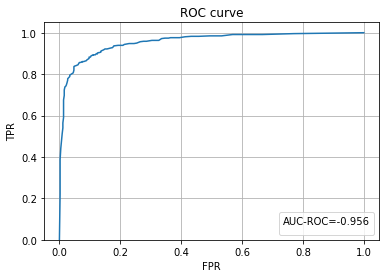

In [21]:
import pandas as pd
from numpy import trapz

y_pred_log = sigmoid(np.dot(w.T,  X_train_tr))
N = 10
plt.figure(figsize = (16,5))
plt.subplot(1,2,1)
plt.plot(y_predicted_train[0,:N],'r', label = 'true')
plt.plot(y_train_tr[0,:N],'--', label = 'class predict')
plt.legend()

plt.subplot(1,2,2)
plt.plot(y_predicted_train[0,:N],'r', label = 'true')
plt.plot(y_pred_log[0,:N],'--',label = 'log predict')
plt.legend()

plt.show()
y  = pd.DataFrame(y_pred_log[0,:])
y[1]=y_train_tr[0,:]


TPR = []
FPR = []
# Введем accuracy
accuracy = {}

mm = np.linspace(0,1,100).tolist()
for i in mm:#arange(len(y.iloc[:,0])):
    tresholds = i#y.iloc[i,0]-0.00000000001
    y_p = y.iloc[:,0]>tresholds
    c = [[np.sum((y.iloc[:,1] ==1)&(y_p == y.iloc[:,1])), np.sum((y.iloc[:,1] ==1)&(y_p != y.iloc[:,1]) ) ],
         [np.sum((y.iloc[:,1] ==0)&(y_p != y.iloc[:,1]) ), np.sum((y.iloc[:,1] ==0)&(y_p == y.iloc[:,1])) ]]
    TP = c[0][0]
    TN = c[1][1]
    FP = c[1][0]
    FN = c[0][1]
    
    TPR.append(TP/(TP+FN))
    FPR.append(FP/(FP+TN))
    
    accuracy[(TP + TN)/(y.shape[0])] = i


AUC_ROC = trapz(TPR, x = FPR, dx=0.1)

plt.title('ROC curve')
plt.ylim(0, 1.05)
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.grid()
plt.legend(' ', title=f'AUC-ROC={AUC_ROC:.3f}', loc='lower right')
plt.plot(FPR, TPR)
plt.show()

### Этот порог и возьмем:

In [22]:
optimal_treshold = accuracy[max(accuracy)]
optimal_treshold

0.6565656565656566

#### Accuracy: 

In [23]:
max(accuracy)

0.8944444444444445

#### Error matrix

In [24]:
y_p = y.iloc[:,0]>optimal_treshold
c = [[np.sum((y.iloc[:,1] ==1)&(y_p == y.iloc[:,1])), np.sum((y.iloc[:,1] ==1)&(y_p != y.iloc[:,1]) ) ],
     [np.sum((y.iloc[:,1] ==0)&(y_p != y.iloc[:,1]) ), np.sum((y.iloc[:,1] ==0)&(y_p == y.iloc[:,1])) ]]
TP = c[0][0]
TN = c[1][1]
FP = c[1][0]
FN = c[0][1]

In [25]:
d = {'y=+1': [TP, FN], 'y=-1':[FP, TN], 'prediction':['a_1(x)=+1', 'a_1(x)=-1']}

In [26]:
matrix = pd.DataFrame(d).set_index('prediction')
matrix

,y=+1,y=-1
prediction,,
a_1(x)=+1,393,29
a_1(x)=-1,66,412


#### Точность

In [27]:
precision = TP / (TP + FP)
TP / (TP + FP)

0.9312796208530806

#### Полнота

In [28]:
recall = TP / (TP + FN)
recall

0.8562091503267973

#### F1 score

In [29]:
F1 = 2*precision*recall/(precision + recall)
F1

0.8921679909194097

## №4
Постройте кривую оббучения (значение оценки потерь от итерации) для примеров из тренировочной и тестовой выборки

Мы не следили за логлоссом на тесте, и не хранили последовательность весов. Прогоним еще раз, внеся заранее нектороые изменения в используемые функции

In [30]:
def optimize(w, X, y, n_iterations, eta):
#     потери будем записывать в список для отображения в виде графика
    losses = []
    losses_test = []
    prev_loss = np.infty
    for i in range(n_iterations):
        loss, grad = log_loss(w, X, y)
        loss2, grad2 = log_loss(w, X_test_tr, y_test_tr)
        w = w - eta * grad
        if np.abs(loss - prev_loss) <= 1e-10:
            return w, losses, losses_test

        losses.append(loss)
        losses_test.append(loss2)
        
    return w, losses, losses_test

In [31]:
# иницилизируем начальный вектор весов
w0 = np.zeros((X_train_tr.shape[0], 1))-1

n_iterations = 20
eta = 9.2

w, losses, losses2 = optimize(w0, X_train_tr, y_train_tr, n_iterations, eta)


y_predicted_test = predict(w, X_test_tr)
y_predicted_train = predict(w, X_train_tr)

# В качестве меры точности возьмем долю правильных ответов
train_accuracy = 100.0 - np.mean(np.abs(y_predicted_train - y_train_tr)*100.0)
test_accuracy = 100.0 - np.mean(np.abs(y_predicted_test-y_test_tr)*100.0)

print(f"Итоговый вектор весов w: {w}")
print(f"Точность на обучающей выборке: {train_accuracy:.3f}")
print(f"Точность на тестовой выборке: {test_accuracy:.3f}")

Итоговый вектор весов w: [[2.92170072e+00]
 [3.76539719e-04]]
Точность на обучающей выборке: 89.111
Точность на тестовой выборке: 89.000


In [32]:
plt.rcParams['figure.figsize'] = [10, 20]

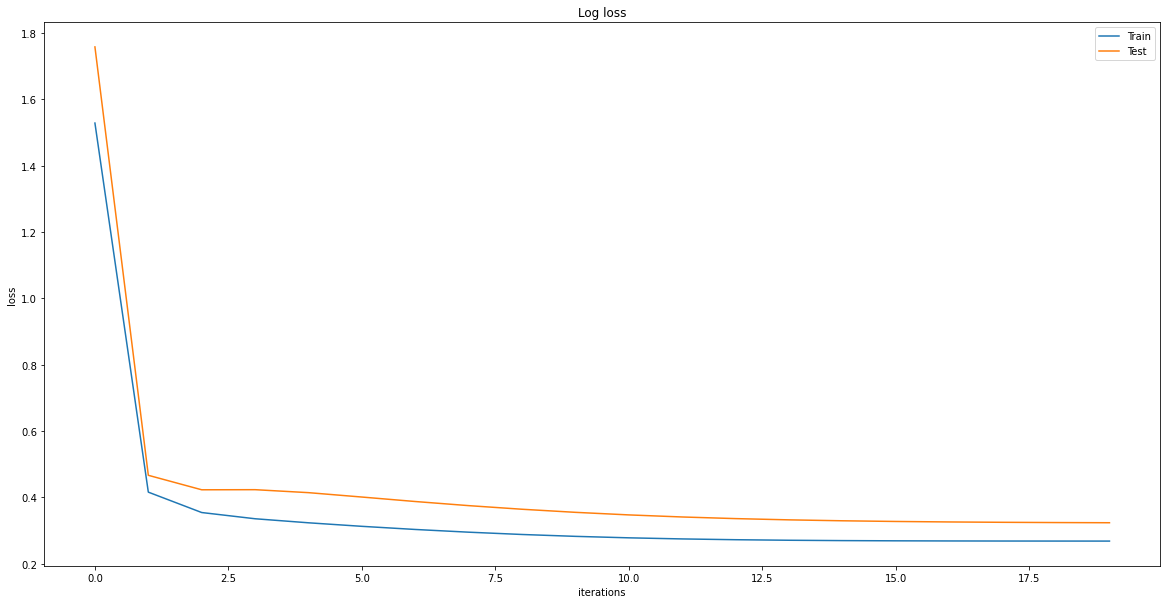

In [33]:
plt.figure(figsize=(20, 10))
plt.title('Log loss')
plt.xlabel('iterations')
plt.ylabel('loss')
plt.plot(range(len(losses)), losses, label = 'Train')
plt.plot(range(len(losses2)), losses2, label = 'Test')
plt.legend()
plt.show()

## № 5-6
* Оцените результаты и сделайте выводы. 
* Попробуйте ответить на вопросы: Могла ли модель переобучиться? На каком шаге это произошло? Почему?

1. Первый вывод: я не умею строить графики. Помогите, пожалуйста! Во-первых, я окончательно запутался, что делает %mathplot inline? Я думал, что он встроит мой график в работу без этого неполноценного окошка. То есть, я могу менять размер графика, но какой смысл, если картины целиком мне неувидеть? 
2. Мы видим, что уже после первого шага тест начинает отставать. Должно ли эт оговорить о переобучении? Я бы сказал нет, к тому же график продолжается уменьшаться. Возможно, это скорее объясняется не самой удачной сортировкой данных или не лучшим делением на тренировочную и тестовою выборки? Я бы так ответил. Пожалуйста, поправьте меня, если я неправ насчет причин переобучения
